In [27]:
import urllib.request 
import tensorflow as tf 
from tensorflow import keras
from IPython.display import HTML, Image
from tensorflow.keras.preprocessing import image

In [28]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

In [29]:
url = '/content/drive/MyDrive/Colab Notebooks/Pigcell'
file_name = 'Pigcell'

In [30]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    url,  
    image_size= (IMAGE_SIZE, IMAGE_SIZE),  
    shuffle=True, seed=500, batch_size= BATCH_SIZE
)

Found 1536 files belonging to 5 classes.


In [31]:
class_names=dataset.class_names
class_names

['01 Neutrophil',
 '02 Lymphocyte',
 '03 Monocyte',
 '04 Eosinophil',
 '05 Basophil']

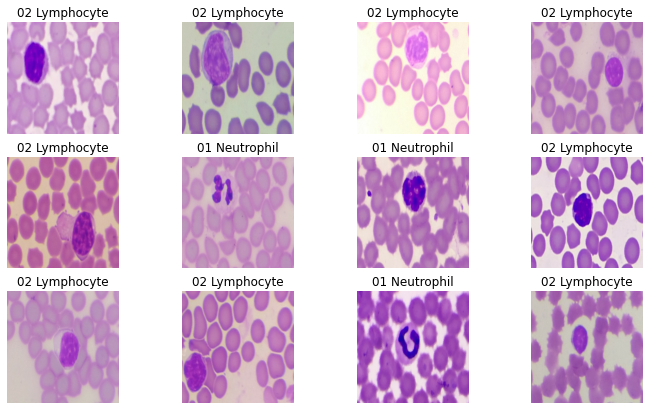

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [33]:
len(dataset)

24

In [34]:
training_dataset=dataset.take(20) 
len(training_dataset)

20

In [35]:
rem_dataset=dataset.skip(20)
len(rem_dataset)

4

In [36]:
validation_dataset = rem_dataset.take(2)
len(validation_dataset)

2

In [37]:
test_dataset = rem_dataset.skip(2)
len(test_dataset)

2

In [38]:
from tensorflow.keras import layers 
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 layers.experimental.preprocessing.RandomRotation(0.2),
])

In [39]:
resize_and_rescale = tf.keras.Sequential([
 layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
 layers.experimental.preprocessing.Rescaling(1./255),
])

In [40]:
# Applying Data Augmentation to Train Dataset 
train_ds = training_dataset.map(
 lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    pooling=None,
    classes=5
)

In [46]:
for layer in resnet.layers:
  layer.trainable = False

In [47]:
x = tf.keras.layers.Flatten()(resnet.output)
prediction = tf.keras.layers.Dense(5, activation = 'softmax')(x)

In [48]:
model = tf.keras.models.Model(inputs = resnet.input, outputs = prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [49]:
model.build(input_shape=IMAGE_SIZE)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

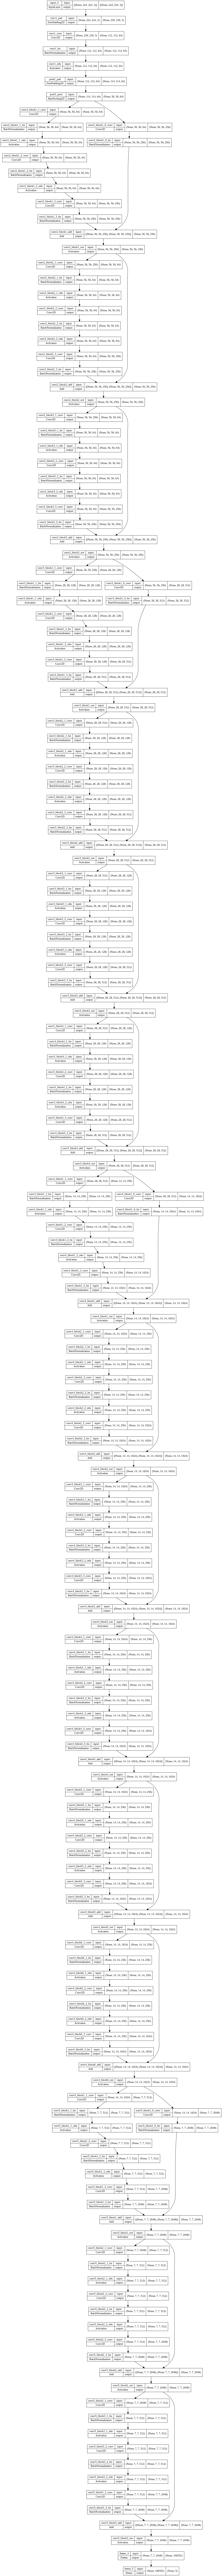

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(model=model, show_shapes=True)

In [51]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

In [52]:
model.compile(
 optimizer='adam',
 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
 metrics=['accuracy']
)

In [53]:
import time
start = time.time()
history=model.fit(
        training_dataset,
        epochs=EPOCHS,
        validation_data=validation_dataset)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
20/20 [==============================] - 177s 9s/step - loss: 11.4651 - accuracy: 0.4703 - val_loss: 3.8666 - val_accuracy: 0.6328
Epoch 2/50
20/20 [==============================] - 16s 716ms/step - loss: 2.3735 - accuracy: 0.7359 - val_loss: 0.9210 - val_accuracy: 0.8438
Epoch 3/50
20/20 [==============================] - 16s 716ms/step - loss: 0.3677 - accuracy: 0.9180 - val_loss: 0.2384 - val_accuracy: 0.9609
Epoch 4/50
20/20 [==============================] - 16s 719ms/step - loss: 0.1090 - accuracy: 0.9734 - val_loss: 0.1005 - val_accuracy: 0.9844
Epoch 5/50
20/20 [==============================] - 16s 724ms/step - loss: 0.0271 - accuracy: 0.9906 - val_loss: 0.0698 - val_accuracy: 0.9922
Epoch 6/50
20/20 [==============================] - 16s 720ms/step - loss: 0.0278 - accuracy: 0.9914 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 7/50
20/20 [==============================] - 16s 721ms/step - loss: 0.0101 - accuracy: 0.9977 - val_loss: 0.0014 - val_accuracy: 1.0000


In [54]:
scores = model.evaluate(test_dataset)
scores

2/2 [==============================] - 5s 390ms/step - loss: 1.6892e-04 - accuracy: 1.0000


[0.00016892363782972097, 1.0]

In [72]:
model.save('ResNet50-on-pigcell.h5')

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']     # val_loss=validation_loss
loss = history.history['loss']
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss']        # val_loss=validation_loss

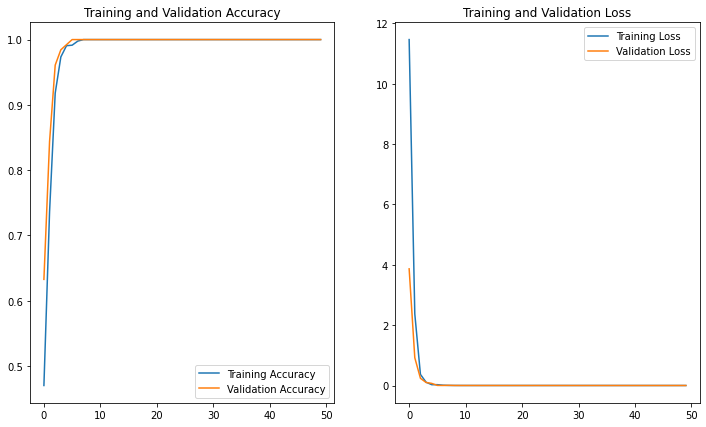

In [56]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: 02 Lymphocyte
predicted label: 02 Lymphocyte


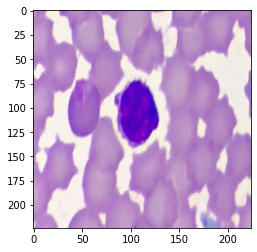

In [57]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
 
 first_image = images_batch[0].numpy().astype('uint8')
 first_label = labels_batch[0].numpy()
 
 print("first image to predict")
 plt.imshow(first_image)
 print("actual label:",class_names[first_label])
 
 batch_prediction = model.predict(images_batch)
 print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [58]:
def predict(model, img):
 img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
 img_array = tf.expand_dims(img_array, 0)
 predictions = model.predict(img_array)
 predicted_class = class_names[np.argmax(predictions[0])]
 confidence = round(100 * (np.max(predictions[0])), 2)
 return predicted_class, confidence

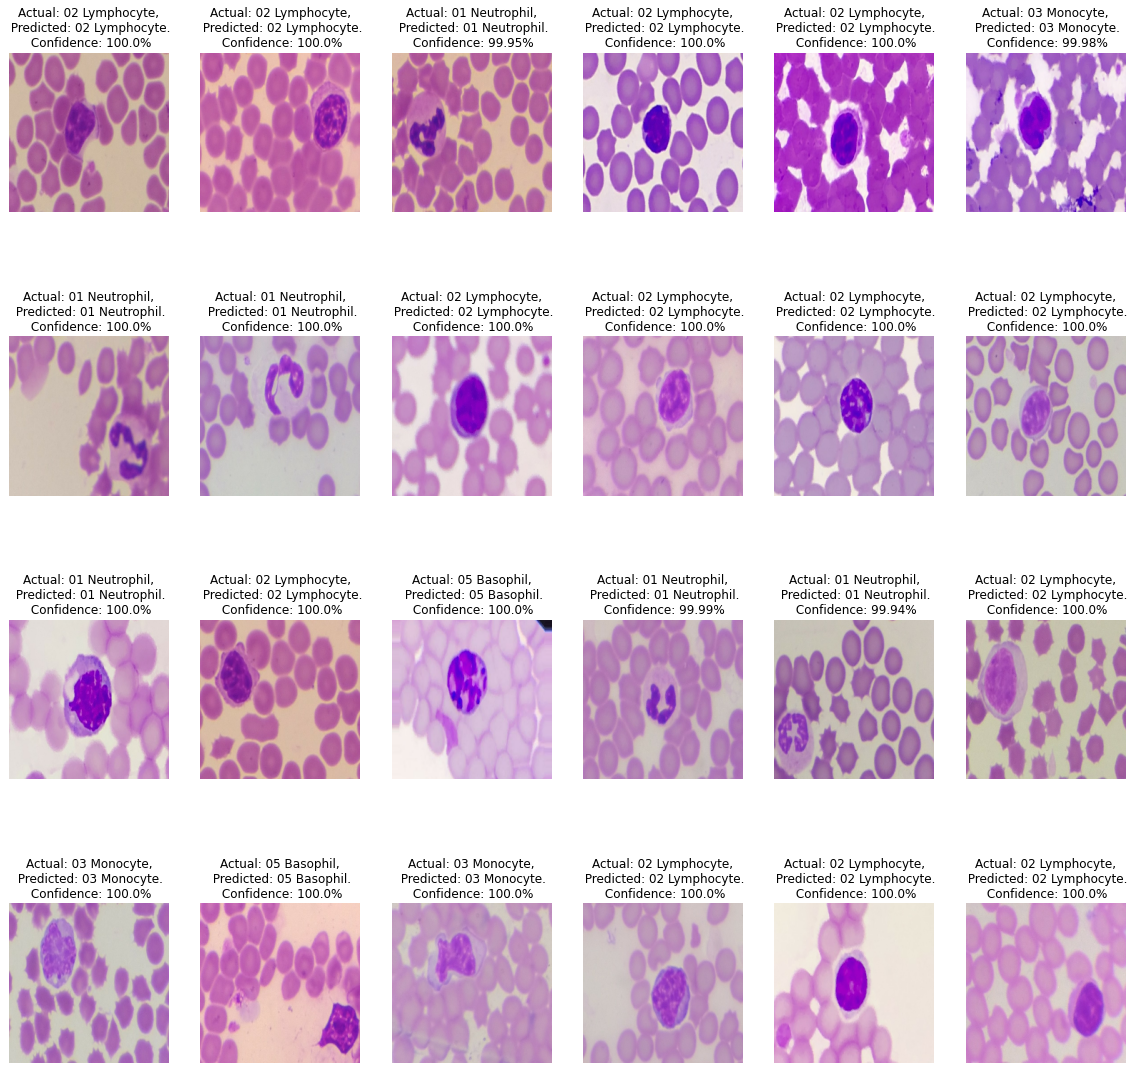

In [59]:
plt.figure(figsize=(20, 20))
for images, labels in test_dataset.take(1):
 for i in range(24):
   ax = plt.subplot(4, 6, i + 1)
   plt.imshow(images[i].numpy().astype("uint8"))
   predicted_class, confidence = predict(model, images[i].numpy())
   actual_class = class_names[labels[i]]
   plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
   plt.axis("off")

In [60]:
%matplotlib inline 
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [61]:
for images_batch, labels_batch in test_dataset.take(1):
    x_test1 = images_batch.numpy().astype('uint8')
    y_test1 = labels_batch.numpy()
    batch_prediction = model.predict(images_batch)
    y_predicted1 = np.argmax(batch_prediction,axis=1)

In [62]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(2):
    x_test2 = images_batch.numpy().astype('uint8')
    y_test2 = labels_batch.numpy()
    batch_prediction = model.predict(images_batch)
    y_predicted2 = np.argmax(batch_prediction,axis=1)

In [63]:
for images_batch, labels_batch in test_dataset.take(3):
    x_test3 = images_batch.numpy().astype('uint8')
    y_test3 = labels_batch.numpy()
    batch_prediction = model.predict(images_batch)
    y_predicted3 = np.argmax(batch_prediction,axis=1)

In [64]:
y_test = np.hstack((y_test1, y_test2, y_test3))
y_predict = np.hstack((y_predicted1, y_predicted2, y_predicted3))

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 37   0   0   0   0]
 [  0 118   0   0   0]
 [  0   0  12   0   0]
 [  0   0   0   7   0]
 [  0   0   0   0  18]]
Normalized confusion matrix
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


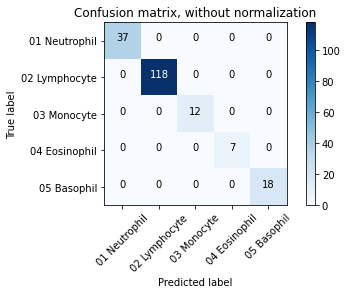

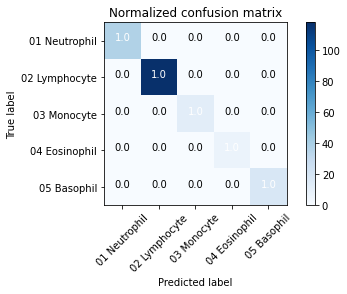

In [79]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test , y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('confusion_matrix_without_normalization.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('confusion_matrix_with_normalization.png')

plt.show()

In [75]:
plt.savefig('confusion_matrix.png')

<Figure size 432x288 with 0 Axes>

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [68]:
# Code for plotting ROC-AUC curve
import numpy as np
from sklearn.metrics import roc_auc_score
def test_model(model, test_dataset):
    score = model.evaluate(test_dataset)
    y_pred_prob = model.predict(test_dataset)
    y_true = test_dataset.classes
    auc_score = roc_auc_score(y_test, y_predict)
    print(f'auc_score {auc_score}')
    return score[1]

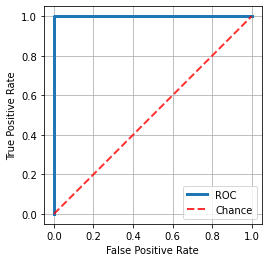

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def plot_roc(model, test_dataset):
    y_predict #= model.predict(test_dataset)
    y_test #= test_dataset.numpy()

    fpr, tpr, _ = roc_curve(y_test , y_predict, pos_label= 4 ) 

    plt.plot(fpr, tpr, label='ROC', linewidth=3)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(
      [0, 1], [0, 1], 
      linestyle='--', 
      linewidth=2, 
      color='r',
      label='Chance', 
      alpha=.8
    )
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend(loc="lower right")
    
plot_roc(model, test_dataset)
plt.savefig('ROC2.png', dpi=500)